<p align="left">
  <img src="https://img.shields.io/badge/Research%20Mode-ON-4cbb17?style=for-the-badge" alt="Research Mode">
</p>

# 02 · Data Exploration — ASAP CRN Learning Lab  
*A guided launchpad for your second ASAP-CRN workspace adventure.*

Welcome to the **ASAP-CRN Learning Lab Pilot Workshop Series!**  

This notebook walks you through the essentials of data inspection and preliminary analyses in **Verily Workbench**.

> 💡 **Tip:** Run each cell in order for the smoothest setup experience.  
> You can always come back later to experiment and make it your own.

In [1]:
# setting up environment
import sys
print(sys.executable)
from pathlib import Path
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)

import os
import math

# matplotlib and seaborn a pythonic alternative to plotnine
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError as e:
    print("Error -> ", e)
    print("Installing seaborn or matplotlib")
    !pip install matplotlib seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt

from PIL import Image

try:
    import scanpy as sc
except ImportError as e:
    print("Error -> ", e)
    print("Installing scanpy")
    !pip install scanpy
    import scanpy as sc

import gc

/usr/bin/python3


# Table of Contents
1. [Workspace Setup](#workspace-setup) 
    - [1.1 Set Dataset Paths](#set-dataset-paths)
    - [1.2 Define Metadata Path](#define-metadata-paths)
    - [1.3 Create Local Directory](#create-local-directory)
2. [Copy Data Locally](#copy-data-locally)
3. [Data Preparation](#prepare-data)  
   - [3.1 Merge Metadata Types](#merge-metadata-types)
   - [3.2 Subset Data](#subset-data)
   - [3.3 Load Full Gene Expression](#load-full-gene-expression)
4. [Data Exploration](#reproducibility-notes)  
5. [Reproducibility Notes](#reproducibility-notes)  
6. [Next Steps](#next-steps)  

## 1. Workspace Setup

### 1.1 Set dataset paths
Next, we define the path to the dataset of interest.  
In this example, we are working with the **PMDBS single‑cell RNA‑seq cohort** dataset:

- **Workflow** → `pmdbs_sc_rnaseq`  
- **Team** → `cohort`  
- **Source** → `pmdbs`  
- **Type** → `sc-rnaseq`  

These components are combined to construct the bucket and dataset names.  
We then set the path to the **cohort analysis outputs** and preview the available files.


In [2]:
#set general folder paths
HOME = Path.home()
WS_ROOT = HOME / "workspace"
DATA_DIR = WS_ROOT / "Data"
WS_FILES = WS_ROOT / "ws_files"

if not WS_ROOT.exists():
    print(f"{WS_ROOT} doesn't exist. We need to remount our resources")
    !wb resource mount    

print("Home directory:     ", HOME)
print("Workspace root:     ", WS_ROOT)
print("Data directory:     ", DATA_DIR)
print("ws_files directory: ", WS_FILES)

print("\nContents of workspace root:")
for p in WS_ROOT.glob("*"):
    print(" -", p.name, "/" if p.is_dir() else "")

Home directory:      /home/jupyter
Workspace root:      /home/jupyter/workspace
Data directory:      /home/jupyter/workspace/Data
ws_files directory:  /home/jupyter/workspace/ws_files

Contents of workspace root:
 - 02_PMDBS_bulkRNAseq /
 - 05_Other_Datasets /
 - 04_Mouse_Spatial /
 - ws_files /
 - release_resources /
 - Documentation /
 - 03_PMDBS_Spatial /
 - 01_PMDBS_scRNAseq /


In [3]:
## Build and set path to desired dataset

DATASETS_PATH = WS_ROOT / "01_PMDBS_scRNAseq"

workflow       = "pmdbs_sc_rnaseq"
dataset_team   = "cohort"
dataset_source = "pmdbs"
dataset_type   = "sc-rnaseq"

bucket_name  = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"

dataset_path = DATASETS_PATH / bucket_name / workflow
print("Dataset Path:", dataset_path)
cohort_analysis_path = dataset_path / "cohort_analysis"

!ls  {cohort_analysis_path} 

Dataset Path: /home/jupyter/workspace/01_PMDBS_scRNAseq/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq
asap-cohort.all_genes.csv
asap-cohort.doublet_score.violin.png
asap-cohort.features.umap.png
asap-cohort.final.h5ad
asap-cohort.final_metadata.csv
asap-cohort.groups.umap.png
asap-cohort.hvg_genes.csv
asap-cohort.merged_cleaned_unfiltered.h5ad
asap-cohort.mmc_otf_mapping.SEAAD.extended_results.json
asap-cohort.mmc_otf_mapping.SEAAD.log.txt
asap-cohort.mmc_otf_mapping.SEAAD.results.csv
asap-cohort.mmc_results.parquet
asap-cohort.n_genes_by_counts.violin.png
asap-cohort.pct_counts_mt.violin.png
asap-cohort.pct_counts_rb.violin.png
asap-cohort.sample_list.tsv
asap-cohort.scanvi_cell_types.parquet
asap-cohort.scanvi_model.tar.gz
asap-cohort.scib_report.csv
asap-cohort.scib_results.svg
asap-cohort.scvi_model.tar.gz
asap-cohort.total_counts.violin.png
MANIFEST.tsv


### 1.2 Define Metadata Path

Alongside the dataset, we also define a path to the **release metadata resources**.  
This folder contains tables describing samples, subjects, brain regions, and experimental conditions.  
Previewing the contents helps us confirm which metadata files are available for integration.


In [4]:
#Define metadata folder path
ds_metadata_path = WS_ROOT / "release_resources/cohort-pmdbs-sc-rnaseq/metadata"

#preview contents
!ls {ds_metadata_path} 

ASSAY_RNAseq.csv  collection_version  PMDBS.csv     STUDY.csv
cde_version	  CONDITION.csv       PROTOCOL.csv  SUBJECT.csv
CLINPATH.csv	  DATA.csv	      SAMPLE.csv


### 1.3 Create Local Output Directory

To keep our work organized, we create a local directory inside `ws_files` called `pilot_workshop_files`.  
This is where we’ll save any outputs (plots, tables, subsetted data) that we want to retain or share.  
If the directory doesn’t exist yet, we create it.


In [5]:
# Define a local path for workshop files
local_data_path = WS_FILES / "pilot_workshop_files"

# Create the directory if it doesn't already exist
if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

print(f"Local data directory ready at: {local_data_path}")

Local data directory ready at: /home/jupyter/workspace/ws_files/pilot_workshop_files


## 2. Copy Data Locally

We now bring in the curated dataset files:

- **`asap-cohort.final_metadata.csv`** → cell‑level metadata table
- **`asap-cohort.final.h5ad`** → full AnnData object containing expression data and annotations  

We copy these files into our local `pilot_workshop_files` directory (if not already present) and load them into memory.  
The metadata CSV is read into a Pandas dataframe, while the `.h5ad` file is loaded as an AnnData object in backed mode.


In [6]:
# Define the expected local path
cell_metadata_local_path = local_data_path / f"asap-{dataset_team}.final_metadata.csv"
if not cell_metadata_local_path.exists():
    cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final_metadata.csv"
    !cp {cell_metadata_og_path} {cell_metadata_local_path}

# load the adata object
cell_metadata_df = pd.read_csv(cell_metadata_local_path, low_memory=False)
print(f"We have loaded the cell_metadata for N={cell_metadata_df.shape[0]} cells")


We have loaded the cell_metadata for N=3046127 cells


In [7]:

adata_local_path = local_data_path / f"asap-{dataset_team}.final.h5ad"

# Check if the adata file already exists locally.
if not adata_local_path.exists():
    adata_cell_metadata_og_path = cohort_analysis_path / f"asap-{dataset_team}.final.h5ad"
    !cp {adata_cell_metadata_og_path} {adata_local_path}

adata = sc.read_h5ad(adata_local_path, backed="r")
adata

AnnData object with n_obs × n_vars = 3046127 × 3000 backed at '/home/jupyter/workspace/ws_files/pilot_workshop_files/asap-cohort.final.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', 'cell_type', 'phenotype', 'rho', 'prob', 'class_name', 'subclass_name', 'supertype_name', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'log1p', 'neighbors', 'pca', 'scr

## 3. Prepare Data

### 3.1 Merge Metadata Types
With both metadata tables and anndata loaded, we can begin prepare the dataset for exploration. A key step is **merging dataset‑level metadata into cell‑level metadata**. This allows us to annotate each cell with experimental conditions and subject information, enabling richer analyses.

Specifically, we combine:
- **Sample‑level metadata** (`SAMPLE.csv`)  
- **Subject‑level metadata** (`SUBJECT.csv`)  
- **Brain sample metadata** (`PMDBS.csv`)  
- **Experimental condition metadata** (`CONDITION.csv`)  

From each table, we select only the relevant columns (IDs, demographics, brain regions, conditions) to keep the merged metadata concise and focused. This merged metadata will later allow us to subset the dataset (e.g., by diagnosis or brain region) and encode Parkinson’s disease state for downstream analysis.


#### Load Metadata Tables & Select Columns

To keep the metadata compact and analysis-ready, we select only the fields needed for:

- identifying samples and subjects
- demographic variables
- brain region information
- condition or diagnosis

In [8]:
# Sample-level metadata
SAMPLE = pd.read_csv(ds_metadata_path / "SAMPLE.csv", index_col=0)
# Subject-level metadata
SUBJECT = pd.read_csv(ds_metadata_path / "SUBJECT.csv", index_col=0)
#  Brain-sample metadata
PMDBS = pd.read_csv(ds_metadata_path / "PMDBS.csv", index_col=0)
# Experimental condition metadata
CONDITION = pd.read_csv(ds_metadata_path / "CONDITION.csv", index_col=0)

# Select Relevant Columns
sample_cols = [
    "ASAP_sample_id",
    "ASAP_subject_id",
    "ASAP_team_id",
    "ASAP_dataset_id",
    "replicate",
    "condition_id",
    "age_at_collection"
]
subject_cols = [
    "ASAP_subject_id",
    "source_subject_id",
    "sex",
    "primary_diagnosis",
]
pmdbs_cols = [
    "ASAP_sample_id",
    "brain_region",
    "region_level_1",
    "region_level_2",
    "region_level_3",
]
condition_cols = [
    "condition_id",
    "intervention_name",
    "intervention_id",
    "protocol_id",
]

#### Prepare Metadata Tables

We now merge the metadata tables step-by-step.
The goal is to construct a single sample-level dataframe (df) that captures all relevant attributes. 

In [9]:
# Merge SAMPLE ↔ CONDITION using condition_id
df = pd.merge(
    SAMPLE[sample_cols], CONDITION[condition_cols], on="condition_id", how="left"
)
# Merge in SUBJECT information
df = pd.merge(df, SUBJECT[subject_cols], on="ASAP_subject_id", how="left")

# Merge in brain-region information
df = pd.merge(df, PMDBS[pmdbs_cols], on="ASAP_sample_id", how="left")

# create unique sample identifier
df["sample"] = df["ASAP_sample_id"] + "_" + df["replicate"]

In [10]:
df.head()


,ASAP_sample_id,ASAP_subject_id,ASAP_team_id,ASAP_dataset_id,replicate,condition_id,age_at_collection,intervention_name,intervention_id,protocol_id,source_subject_id,sex,primary_diagnosis,brain_region,region_level_1,region_level_2,region_level_3,sample
0,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
1,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
2,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,Control,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
3,ASAP_PMBDS_000026_s001,ASAP_PMBDS_000026,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,81.0,Case-Control,NaN,NaN,hSDG07,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000026_s001_Rep1
4,ASAP_PMBDS_000027_s001,ASAP_PMBDS_000027,TEAM_HAFLER,DS_PMDBS_0002,Rep1,Control,65.0,Case-Control,NaN,NaN,hSDG13,Female,Healthy Control,Prefrontal Cortex,Frontal lobe,Prefrontal cortex,Grey matter,ASAP_PMBDS_000027_s001_Rep1


#### Metadata Cleaning (Fixing Inconsistencies)

Before assigning brain region or diagnosis labels to each cell, we correct a few inconsistencies across the original metadata submissions.
Different contributing teams may have used slightly different spellings, capitalization, or ontology mappings; this step ensures everything is harmonized for downstream analysis.

In [11]:
# Recode brain region to be "PFC", "MFG", "HIP", "SN", "ACG", "IPL, "AMG", "PUT"
brain_fix = {
    "Prefrontal Cortex": "PFC",
    "Middle_Frontal_Gyrus": "MFG",
    "Hippocampus": "HIP",
    "Substantia_Nigra ": "SN",
    "ACG": "ACG",
    "IPL": "IPL",
    "Middle temporal gyrus": "MTG",
    "Substantia nigra": "SN",
    "Prefrontal cortex": "PFC",
    "Amygdala": "AMG",
    "Putamen": "PUT",
}
df["brain_region"] = df["brain_region"].map(brain_fix)

In [12]:
# Map to find more course designations
brain_simple = {
    "PFC": "frontal_ctx",
    "MFG": "frontal_ctx",
    "ACG": "cingulate_ctx",
    "IPL": "parietal_ctx",
    "MTG": "temporal_ctx",
    "HIP": "subcortical",
    "AMG": "subcortical",
    "PUT": "subcortical",
    "SN": "subcortical",
}

df["brain_region_simple"] = df["brain_region"].map(brain_simple)


# Define sample to match
br_mapper_full = dict(zip(df["sample"], df["brain_region"]))
br_mapper_simple = dict(zip(df["sample"], df["brain_region"].map(brain_simple)))

# Parkinsons and control samples
condition_id_mapper = dict(zip(df["sample"], df["condition_id"]))
case_id_mapper = dict(zip(df["sample"], df["intervention_name"]))

# Detailed brain region mapper 
region_1_mapper = dict(zip(df["sample"], df["region_level_1"]))
region_2_mapper = dict(zip(df["sample"], df["region_level_2"]))

# Diagnoses
diagnoses_mapper = dict(zip(df["sample"], df["primary_diagnosis"]))

#### Save Merged Metadata

Now that the dataset-level metadata is assembled, we save it for later use.

In [13]:
dataset_metadata_filen = local_data_path / "asap-cohort-dataset-metadata.csv"
df.to_csv(dataset_metadata_filen)

### 3.3 Dataset Composition Overview

Before we subset the data, we take a high-level look at how cells are distributed across the full asap-cohort dataset.These summaries help us understand overall dataset balance, sampling depth, and the representation of conditions and brain regions.

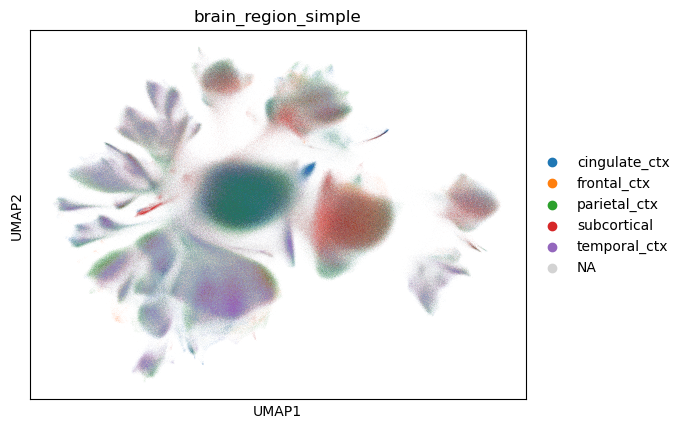

In [21]:
# Map samples to metadata
adata.obs["brain_region"] = adata.obs["sample"].map(br_mapper_full)
adata.obs["brain_region_simple"] = adata.obs["sample"].map(br_mapper_simple)
adata.obs["case_id"] = adata.obs["sample"].map(case_id_mapper)

# UMAP - Brain Region Simple
sc.pl.embedding(adata, basis="umap", color=["brain_region_simple"])

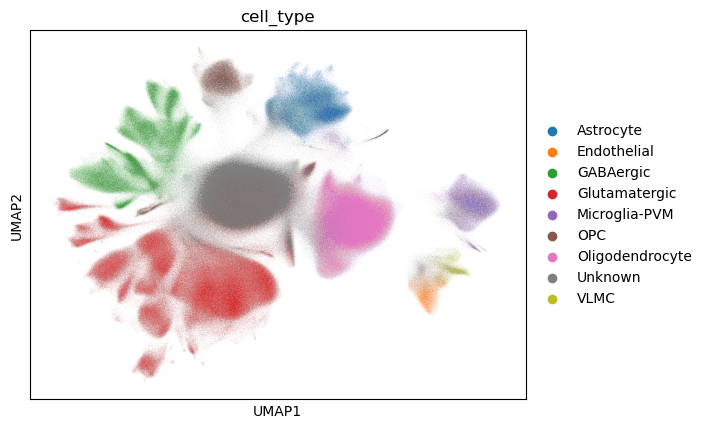

In [22]:
# UMAP - Cell Type
sc.pl.embedding(adata, basis="umap", color=["cell_type"])

In [ ]:
# Define plot groups and their respective metadata columns
plot_groups = {
    "Quality Control Metrics": ["pct_counts_rb", "pct_counts_mt"],
    "Cell Quality Metrics": ["doublet_score", "n_genes_by_counts"],
    # 'Batch Information': ['batch', 'batch_id'],
    # 'Cell Phase and Type': ['phase', 'cell_type']
}


# Iterate over plot groups and create separate figures
for group_name, metadata_cols in plot_groups.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(group_name)

    for i, metadata_col in enumerate(metadata_cols):
        sns.scatterplot(
            x="UMAP_1",
            y="UMAP_2",
            hue=metadata_col,
            data=cell_metadata_df,
            ax=axes[i],
            s=2,
            alpha=0.5,
        )
        axes[i].set_title(f"{metadata_col}")
        axes[i].set_xlabel("UMAP_1")
        axes[i].set_ylabel("UMAP_2")
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

## 3.4 Subsetting the Dataset

The full `asap-cohort` **PMDBS snRNA-seq dataset** contains gene expression measurements for **millions of cells** across **tens of thousands of genes**. For efficient analysis and clearer demonstrations in this workshop, we will focus on a biologically relevant subset: **prefrontal cortex (PFC) cells.**

This reduced dataset retains:
- the **full gene expression matrix** for these cells,
- all **metadata** fields, and
- the **shared cohort latent space** used for UMAPs and downstream analyses.

> **Why Subset?**
> It reduces memory and compute requirements while still supporting PD-relevant comparisons (e.g., case vs. control).


> **Alternate strategy:**
> You could load each contributing dataset individually and analyze them separately, which is less resource-intensive. However, for this workshop we leverage the shared cohort latent space to enable consistent UMAP visualization and cross-dataset comparisons.


#### Subsetting by Brain Region and Case/Control Status

We begin by identifying all cells annotated as originating from prefrontal cortex samples, then exclude ambiguous “Other” case labels. 

This prepares the dataset for:
- pseudo-bulk differential expression
- cross-dataset meta-analysis
- UMAP visualization in the shared cohort embedding

In [ ]:

# Identify frontal cortex cells
frontal_cells = adata.obs["brain_region_simple"] == "frontal_ctx"

# Exclude samples with ambiguous case labels
case_control_cells = ~(adata.obs["case_id"] == "Other")

# Final boolean mask for subsetting
include = frontal_cells & case_control_cells

#### Create the Prefrontal Cortex Subset

With our filters defined, we can now extract the frontal cortex case/control cells into a new **in-memory** `AnnData` object.

> **Note:**  
> The full cohort dataset is read in *backed* mode, meaning it is **not** loaded into memory.  
> Here we extract the prefrontal cortex cells **into memory** and then close the backed file.



In [ ]:
frontal_ad = adata[include].to_memory()
adata.file.close()  # close the original adata file

The resulting subset will serve as the basis for our downstream analyses in this workshop.

#### Add metadata to our subsetted cohort data (`frontal_ad.obs`)

In [ ]:
frontal_ad.obs["condition_id"] = frontal_ad.obs["sample"].map(condition_id_mapper)
frontal_ad.obs["case_id"] = frontal_ad.obs["sample"].map(case_id_mapper)
frontal_ad.obs["brain_region"] = frontal_ad.obs["sample"].map(br_mapper_full)
frontal_ad.obs["brain_region_simple"] = frontal_ad.obs["sample"].map(br_mapper_simple)
frontal_ad.obs["region_level_1"] = frontal_ad.obs["sample"].map(region_1_mapper)
frontal_ad.obs["region_level_2"] = frontal_ad.obs["sample"].map(region_2_mapper)
frontal_ad.obs["primary_diagnosis"] = frontal_ad.obs["sample"].map(diagnoses_mapper)

Let's take a look at the subset composition

In [ ]:
frontal_ad.obs["condition_id"].value_counts()

In [ ]:
# UMAP - Cell Type
sc.pl.embedding(adata, basis="umap", color=["condition_id"])

#### Exporting the Subset

Let's save the prefrontal cortex case/control subset as a standalone `AnnData` object.  This gives us a lightweight artifact that preserves embeddings, annotations, and cohort-level integration results.


In [70]:
frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_case_control_samples.h5ad"
)
frontal_ad.write_h5ad(frontal_samples_filename)

#remove files from memory
del adata, frontal_ad
gc.collect()

14059

### 3.3 Load Full Gene Expression for the Subset

The subset we created so far contains **only highly variable genes**, which is ideal for integration and visualization but not always sufficient for:
- gene-level exploration  
- marker discovery  
- differential expression

To recover **full gene expression** for the same cells, we:

1. Load the **full, unfiltered cohort AnnData** (backed on disk).  
2. Reload the **subset AnnData** that defines the exact cell set of interest.  
3. Use the subset’s cell index (`obs_names`) to extract the corresponding rows from the full matrix.  

This gives us an `X` matrix with full gene coverage for the PFC case/control cells, while still leveraging the integrated latent space from the cohort workflow.


In [ ]:
# Define file paths 
full_adata_filename = (
    cohort_analysis_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)
l_full_adata_filename = (
    local_data_path / f"asap-{dataset_team}.merged_cleaned_unfiltered.h5ad"
)

if not l_full_adata_filename.exists():
    !cp {full_adata_filename} {l_full_adata_filename}

In [ ]:
# Load full expression matrix
full_adata = sc.read_h5ad(l_full_adata_filename, backed="r")

In [ ]:
# Reload PFC cell subset
frontal_ad = sc.read_h5ad(frontal_samples_filename, backed="r")

# Extract and select PFC cells from complete gene expression matrix
var_ = full_adata.var.copy()
X = full_adata[frontal_ad.obs_names].X.copy()

full_adata.file.close()

Now we can combine the _full_ gene expression matrix with our frontal cortex subset, and save the resulting `AnnData`object.

In [ ]:
frontal_full_ad = sc.AnnData(
    X=X,
    obs=frontal_ad.obs,
    var=var_,
    uns=frontal_ad.uns,
    obsm=frontal_ad.obsm,
)

In [ ]:
frontal_full_ad.obs.head()

In [ ]:
# Save full frontal cortex Anndata object
frontal_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"
)
frontal_full_ad.write_h5ad(frontal_full_samples_filename)

## 4. Data Exploration

With our subset prepared, we can now explore the dataset to understand its structure, quality, and biological composition.
This section walks through:
1. Sample composition
2. Cell composition
3. QC metric distributions
4. Integrated embeddings (UMAP)

These steps help build an intuitive overview of the dataset before moving into deeper analyses.

### 4.1 Sample Composition

First, let's summarize the number of samples contributing to this subset and how they break down across metadata categories such as:
- Case vs Control
- Diagnosis
- Brain region (frontal cortex only, but with fine-grained sublabels if available)

This provides context for downstream PD analyses and highlights any imbalances between groups.

In [ ]:
# Create a contingency table
ct = pd.crosstab(frontal_full_ad.obs["condition_id"], frontal_ad.obs["primary_diagnosis"])

# Plot stacked bar chart
ct.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Cell Counts by Case/Control Status (stacked by Diagnosis)")
plt.xlabel("Case/Control")
plt.ylabel("Number of Cells")
plt.xticks(rotation=45)
plt.legend(title="Diagnosis", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 4.2 Cell Composition

Next, we examine how cells are distributed across metadata categories. This helps answer questions like:
- How many cells were captured per sample?
- Are there differences in cell counts between case vs control?
- Are any samples under- or over-represented?

In [ ]:
# Count cells per sample
cells_per_sample = frontal_full_ad.obs["sample"].value_counts()

plt.figure(figsize=(10,4))
sns.barplot(x=cells_per_sample.index, y=cells_per_sample.values)
plt.title("Number of Cells Captured per Sample")
plt.xlabel("Sample ID")
plt.ylabel("Number of Cells")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
cell_counts = frontal_full_ad.obs["cell_type"].value_counts()

plt.figure(figsize=(10,4))
sns.barplot(x=cell_counts.index, y=cell_counts.values)
plt.xticks(rotation=90)
plt.title("Cell Counts per Cell Type,")
plt.ylabel("Number of Cells")
plt.show()


### 4.3 QC Distributions by Group

We now examine QC metrics across biologically relevant groups.
These plots are useful for detecting technical differences between:
- Case vs Control
- Brain region labels
- Contributing datasets
                      
**Common QC metrics include:**
- n_genes_by_counts
- total_counts
- pct_counts_mt
- pct_counts_rb
- doublet_score

In [ ]:
qc_metrics = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_rb"]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, m in zip(axes.flatten(), qc_metrics):
    sns.violinplot(data=frontal_full_ad.obs, x="condition_id", y=m, cut=0, ax=ax)
    ax.set_title(f"{m} by Case/Control Status")
    ax.set_xlabel("Case/Control")
    ax.set_ylabel(m)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


### 4.4 Explore Integrated Embeddings (UMAP)

Finally, we visualize the prefrontal cortex cells in the shared cohort UMAP embedding.
This reveals overall structure of:

- major cell populations
- batch or dataset mixing
- case vs control separation (if present)
- region-specific differences
- donor variability

In [ ]:
sc.pl.embedding(frontal_ad, basis="umap", color=["condition_id"])

In [ ]:
sc.pl.embedding(frontal_ad, basis="umap", color=["cell_type"])